# Earthquake Detection

In [1]:
import numpy as np
import pandas as pd
import obspy
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pywt

from matplotlib import cm
from scipy import signal
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset, z_detect

# Visualization of all Cases

Thanks for the code @Rohan!

In [2]:
base_dir = Path("../data/space_apps_2024_seismic_detection")
cat_file = base_dir / "data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv"
cat = pd.read_csv(cat_file)
# for convenient access
cat["arrival_time"] = pd.to_datetime(cat["time_abs(%Y-%m-%dT%H:%M:%S.%f)"])
cat["arrival_time_rel"] = cat["time_rel(sec)"]

print(len(cat))
cat.head()

76


filename time_abs(%Y-%m-%dT%H:%M:%S.%f)  \
0  xa.s12.00.mhz.1970-01-19HR00_evid00002     1970-01-19T20:25:00.000000   
1  xa.s12.00.mhz.1970-03-25HR00_evid00003     1970-03-25T03:32:00.000000   
2  xa.s12.00.mhz.1970-03-26HR00_evid00004     1970-03-26T20:17:00.000000   
3  xa.s12.00.mhz.1970-04-25HR00_evid00006     1970-04-25T01:14:00.000000   
4  xa.s12.00.mhz.1970-04-26HR00_evid00007     1970-04-26T14:29:00.000000   

   time_rel(sec)       evid    mq_type        arrival_time  arrival_time_rel  
0        73500.0  evid00002  impact_mq 1970-01-19 20:25:00           73500.0  
1        12720.0  evid00003  impact_mq 1970-03-25 03:32:00           12720.0  
2        73020.0  evid00004  impact_mq 1970-03-26 20:17:00           73020.0  
3         4440.0  evid00006  impact_mq 1970-04-25 01:14:00            4440.0  
4        52140.0  evid00007    deep_mq 1970-04-26 14:29:00           52140.0

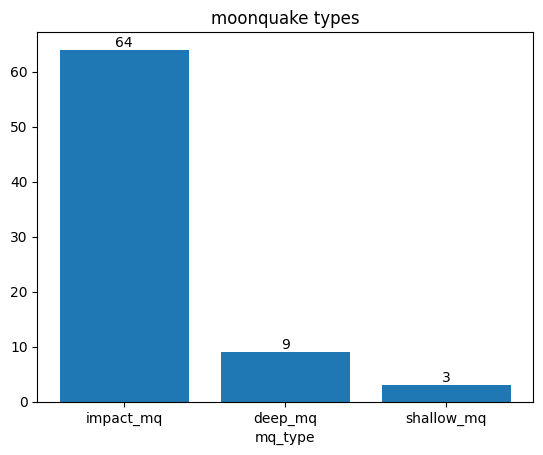

In [3]:
mq_type_counts = cat["mq_type"].value_counts()
bars = plt.bar(mq_type_counts.index, mq_type_counts.values)
plt.xlabel("mq_type")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:,}",
        ha="center",
        va="bottom",
    )

plt.title("moonquake types")
plt.show()


In [4]:
train_dir = base_dir / "data/lunar/training/data/"
test_dir = base_dir / "data/lunar/test/data/"

# get from df so we can match with arrival times
train_filenames = [train_dir / f"S12_GradeA/{x}.mseed" for x in cat.filename]
test_filenames = list(test_dir.rglob("*.mseed"))

print("training data: ", len(list(train_dir.rglob("*.mseed"))))
print("test data: ", len(test_filenames))

training data:  76
test data:  96


In [5]:
print("train data")
# for evid00029, one of the files says HR02 instead of HR00 (as in the catalog)
for f in train_filenames:
    try:
        read(f)
    except Exception as e:
        print(f"Error reading file {f}: {e}")

print("test data")
for f in test_filenames:
    try:
        read(f)
    except Exception as e:
        print(f"Error reading file {f}: {e}")

train data
Error reading file ..\data\space_apps_2024_seismic_detection\data\lunar\training\data\S12_GradeA\xa.s12.00.mhz.1971-04-13HR00_evid00029.mseed: [Errno 2] No such file or directory: '..\\data\\space_apps_2024_seismic_detection\\data\\lunar\\training\\data\\S12_GradeA\\xa.s12.00.mhz.1971-04-13HR00_evid00029.mseed'
test data


In [6]:
for i, f in enumerate(train_filenames):
    if "evid00029" in str(f):
        train_filenames[i] = Path(
            "../data/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR02_evid00029.mseed"
        )
train_streams = []
for f in train_filenames:
    try:
        train_streams.append(read(f))
    except Exception as e:
        print(f"Error reading file {f}: {e}")

test_streams = []
for f in test_filenames:
    try:
        test_streams.append(read(f))
    except Exception as e:
        print(f"Error reading file {f}: {e}")

In [7]:
train_streams[0][0].stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1970-01-19T00:00:00.665000Z
         endtime: 1970-01-20T00:00:02.778208Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572415
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

## Visualizing the training and testing data

In [8]:
def get_time_speed(stream: obspy.core.stream.Stream):
    # all have just one trace
    trace = stream[0]
    tr_times = trace.times()
    tr_data = trace.data

    
    return tr_times, tr_data

# Moonquakes

{'impact_mq': (np.float64(0.12156862745098039), np.float64(0.4666666666666667), np.float64(0.7058823529411765), np.float64(1.0)), 'deep_mq': (np.float64(1.0), np.float64(0.4980392156862745), np.float64(0.054901960784313725), np.float64(1.0)), 'shallow_mq': (np.float64(0.17254901960784313), np.float64(0.6274509803921569), np.float64(0.17254901960784313), np.float64(1.0))}


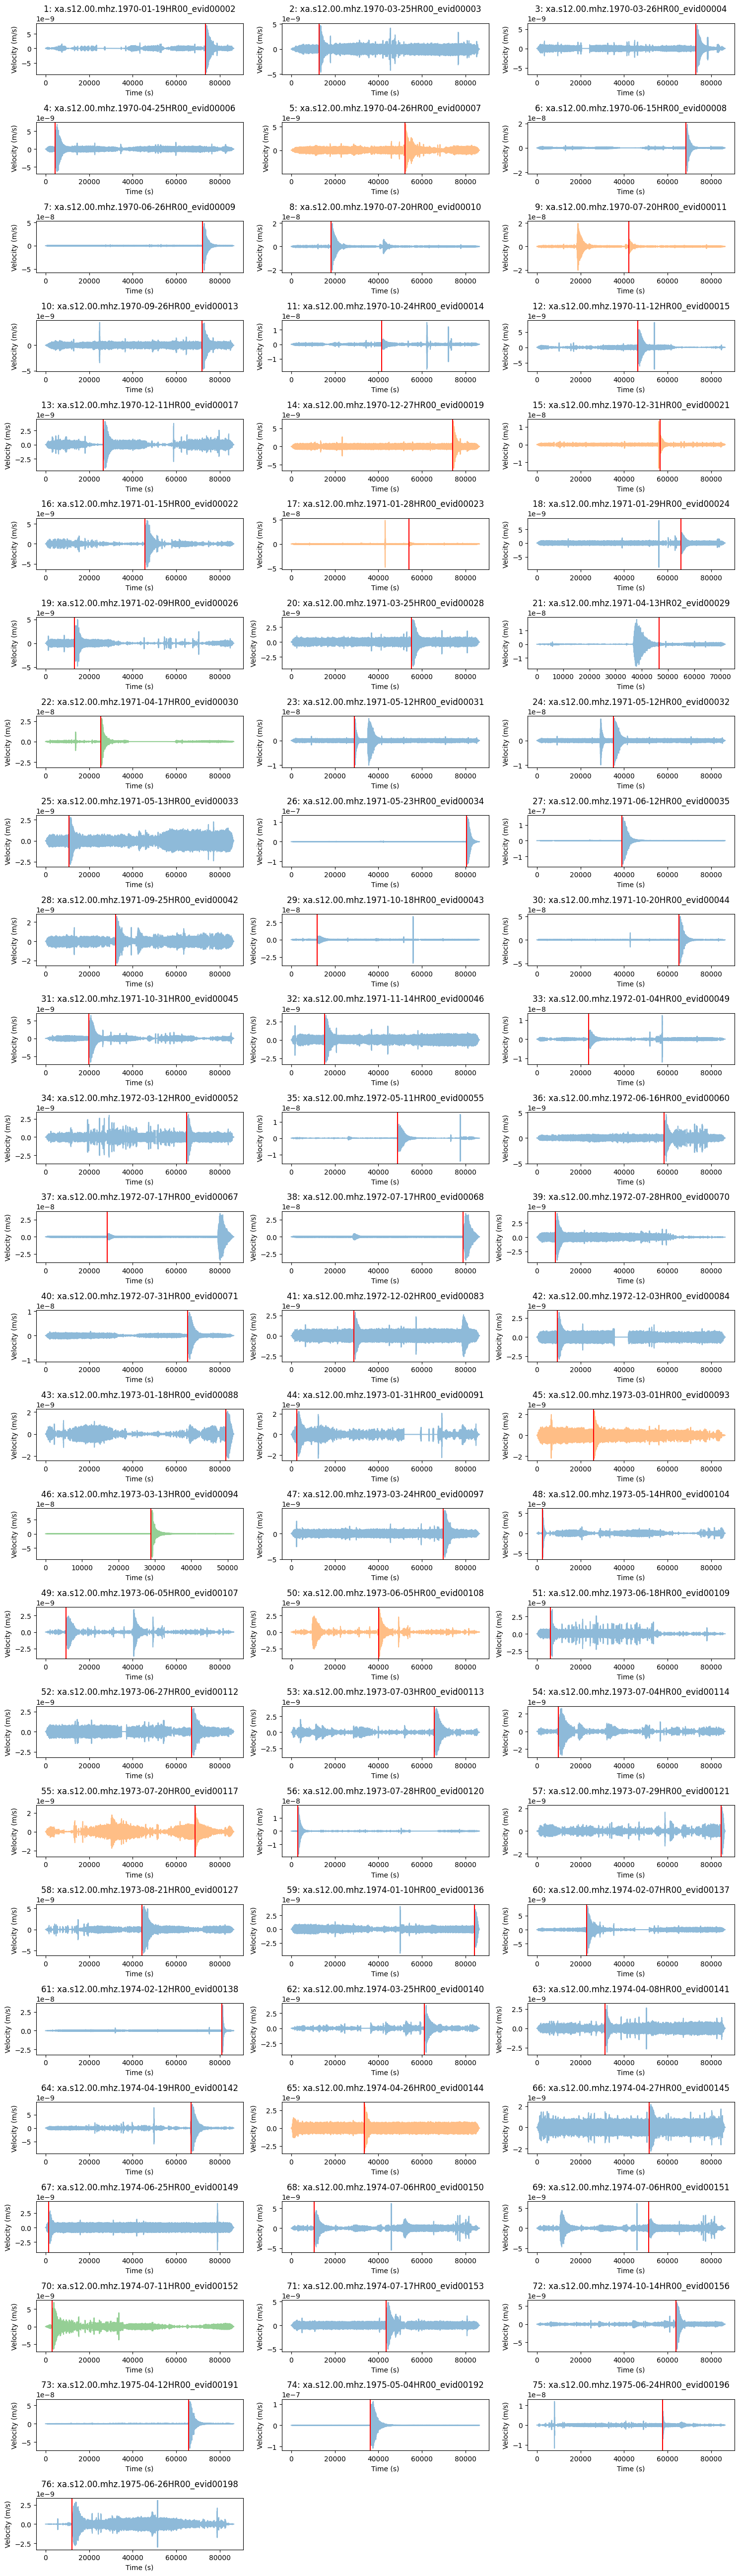

In [9]:
nrows = (len(train_streams) + 2) // 3
fig, axs = plt.subplots(nrows, 3, figsize=(15, 2 * nrows))
axs = axs.flatten()

unique_mq_types = cat["mq_type"].nunique()
color_map = plt.colormaps["tab10"]
color_dict = {mq: color_map(i) for i, mq in enumerate(cat["mq_type"].unique())}
print(color_dict)
for i, stream in enumerate(train_streams):
    x, y = get_time_speed(stream)

    mq_type = cat.loc[i, "mq_type"]
    color = color_dict[mq_type]

    axs[i].plot(x, y, color=color, alpha=0.5)
    axs[i].axvline(x=cat.loc[i, "arrival_time_rel"], c="red")
    axs[i].set_title(f"{i+1}: {train_filenames[i].stem}")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Velocity (m/s)")

for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

ev29 is a faulty example, it has been mis labelled. Onto the test data.

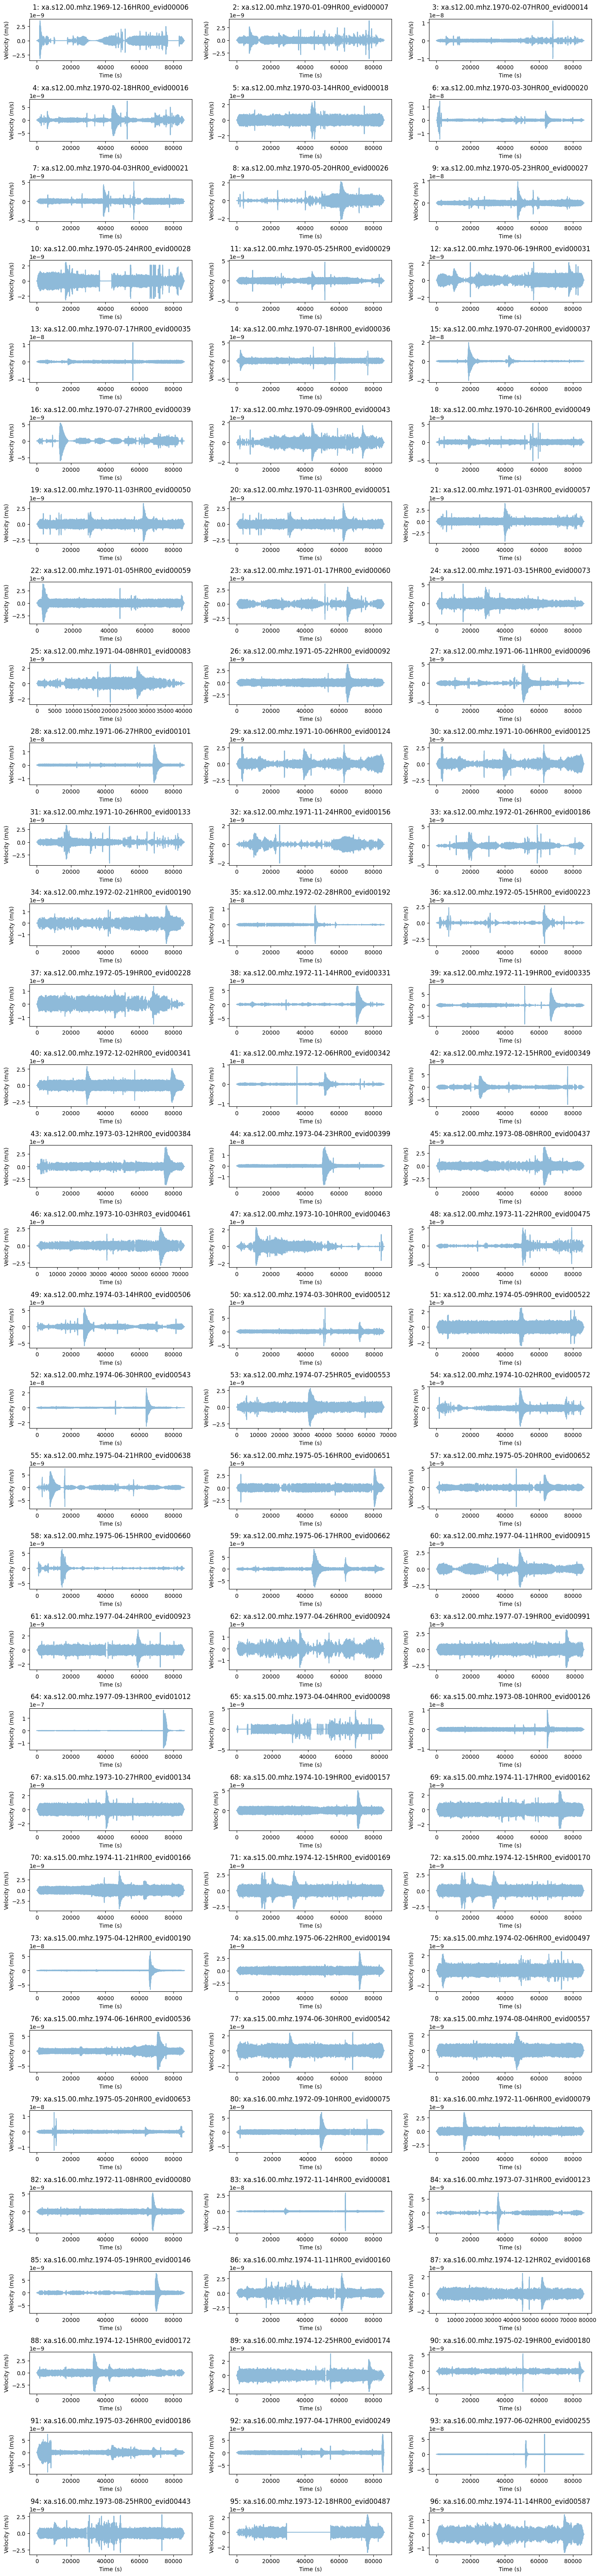

In [10]:
nrows = (len(test_streams) + 2) // 3
fig, axs = plt.subplots(nrows, 3, figsize=(15, 2 * nrows))
axs = axs.flatten()


for i, stream in enumerate(test_streams):
    x, y = get_time_speed(stream)
    axs[i].plot(x, y, alpha=0.5)
    axs[i].set_title(f"{i+1}: {test_filenames[i].stem}")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Velocity (m/s)")

for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

LTA/STA needs preprocessing and denoising to be useful. But there are some things to keep in mind:

To apply LTA/STA, we need to understand 4 quantities:

1) STA Window Duration: 
    - STA moving average window. 
    - < LTA window. Rarely equal.
    - Set too high: miss out on shorter earthquakes.
    - Set too low: will start registerning noise as earthquakes.
    - **On Earth** for regional events: set 1-2 seconds. For local events and shorted quakes, Set to 0.3-0.5 seconds is common. (These values are based on Huerisitcs.)

2) LTA Window Duration:
    - LTA moving average window.
    - LTA set too low: excludes regional events.
    - LTA set too high: will start falsely triggering noise.

3) Trigger On Threshold:
    - Minimum value that LTA/STA ratio should exceed to consider an earthquake has started.

4) Trigger Off Threshold:
    - Minimum values that the LTA/STA ratio has to drop to drop to to signal that an eathquake has ended.
    - Not really required for our purpose.

All in all, these value require a good understanding of what we need out of seismic data. 

In [11]:
def sta_lta_wfilter(stream: obspy.core.stream.Stream):
    # all have just one trace
    trace = stream[0].filter('bandpass',freqmin=0.8,freqmax=1.9)
    tr_times = trace.times()
    tr_data = trace.data

    sr = trace.stats.sampling_rate

    sta_len = 300
    lta_len = 3000


    cft = classic_sta_lta(tr_data, int(sta_len*sr), int(lta_len*sr)) 
    t_on  = 4
    t_off = 1.5
    tr = trigger_onset(cft, t_on, t_off)
    
    return tr_times, cft, tr

After several tries, for the STA/LTA to work somewhat properly, I have used the following settings:

    - Bandpass filter: b/w 0.8-1.9 Hz.

    - Sta_window_length: 300 sec.

    - LTA_window_length: 3000 sec.

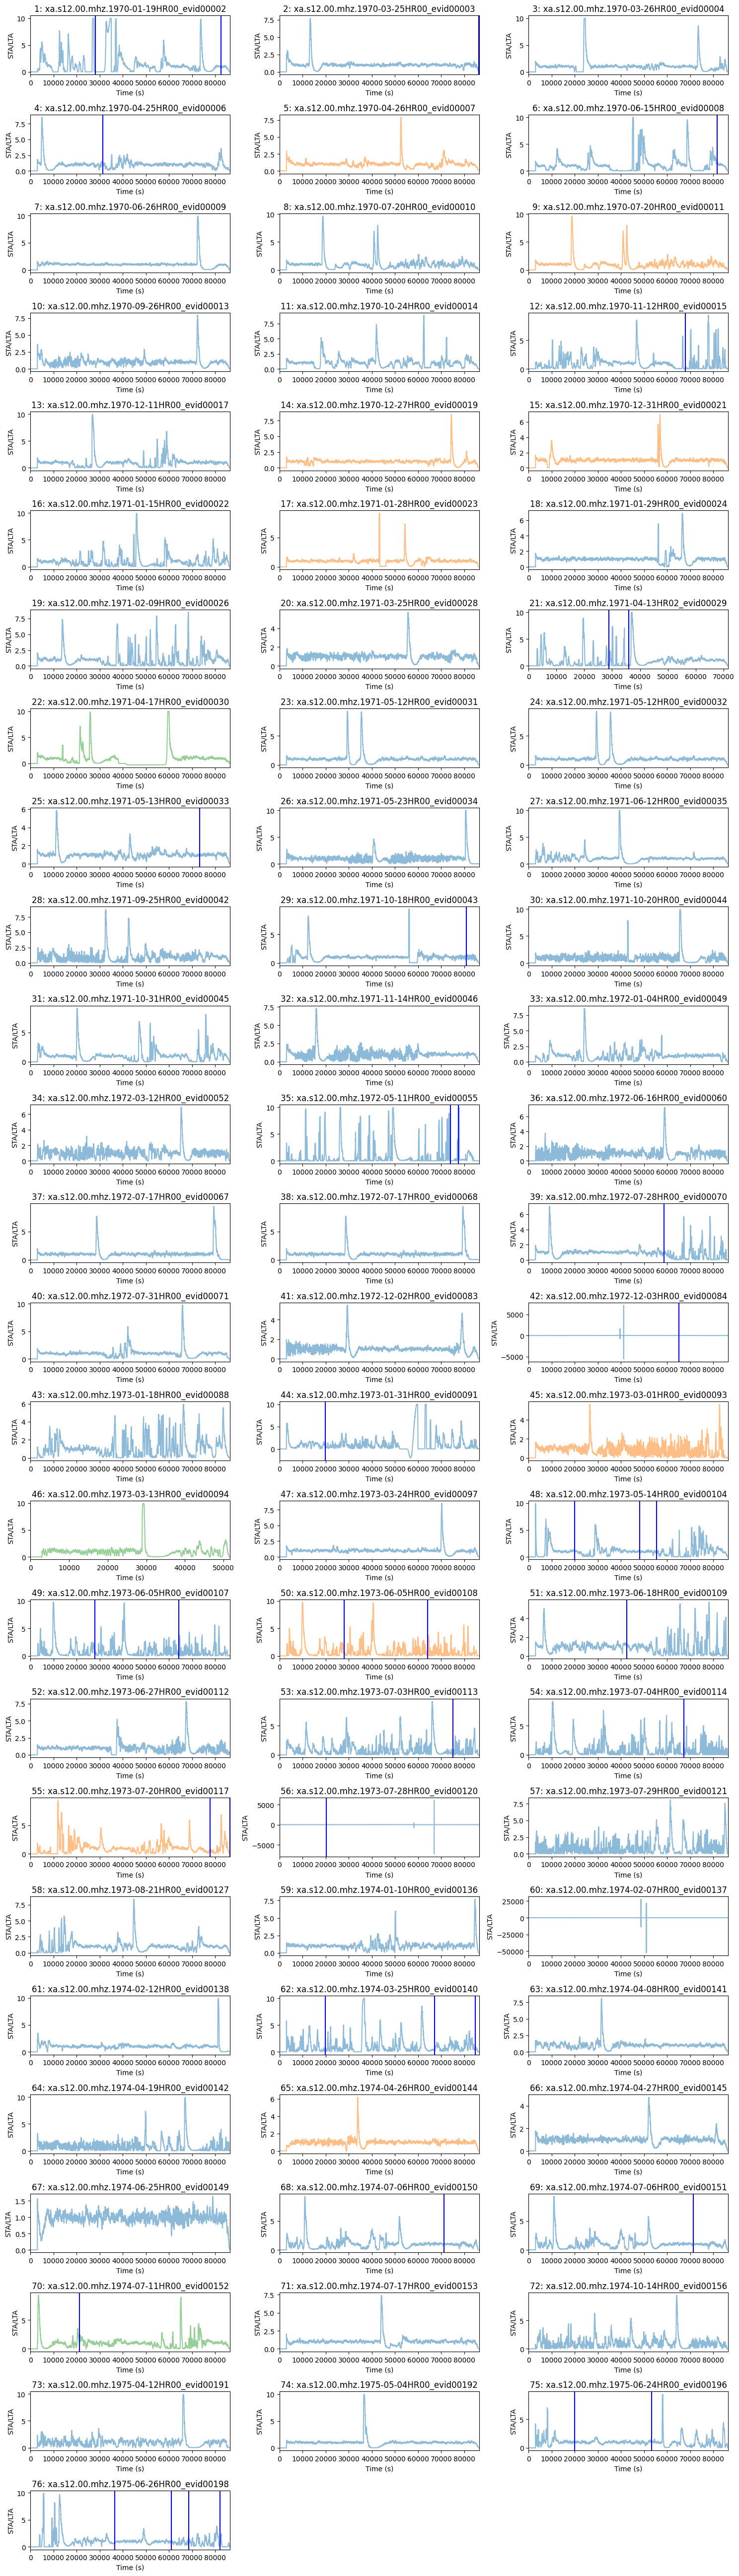

In [12]:
nrows = (len(train_streams) + 2) // 3
fig, axs = plt.subplots(nrows, 3, figsize=(15, 2 * nrows))
axs = axs.flatten()

unique_mq_types = cat["mq_type"].nunique()
color_map = plt.colormaps["tab10"]
color_dict = {mq: color_map(i) for i, mq in enumerate(cat["mq_type"].unique())}
for i, stream in enumerate(train_streams):
    x, y, tr = sta_lta_wfilter(stream)

    mq_type = cat.loc[i, "mq_type"]
    color = color_dict[mq_type]

    axs[i].plot(x, y, color=color, alpha=0.5)
    for k in tr:
        axs[i].axvline(x=k[0], c="blue")
    axs[i].set_title(f"{i+1}: {train_filenames[i].stem}")
    axs[i].set_xlim([min(x),max(x)])
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("STA/LTA")

for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

STA/LTA not very useful without filtering. With this also there will be a high probabability of false detections. 

# Spectrogram

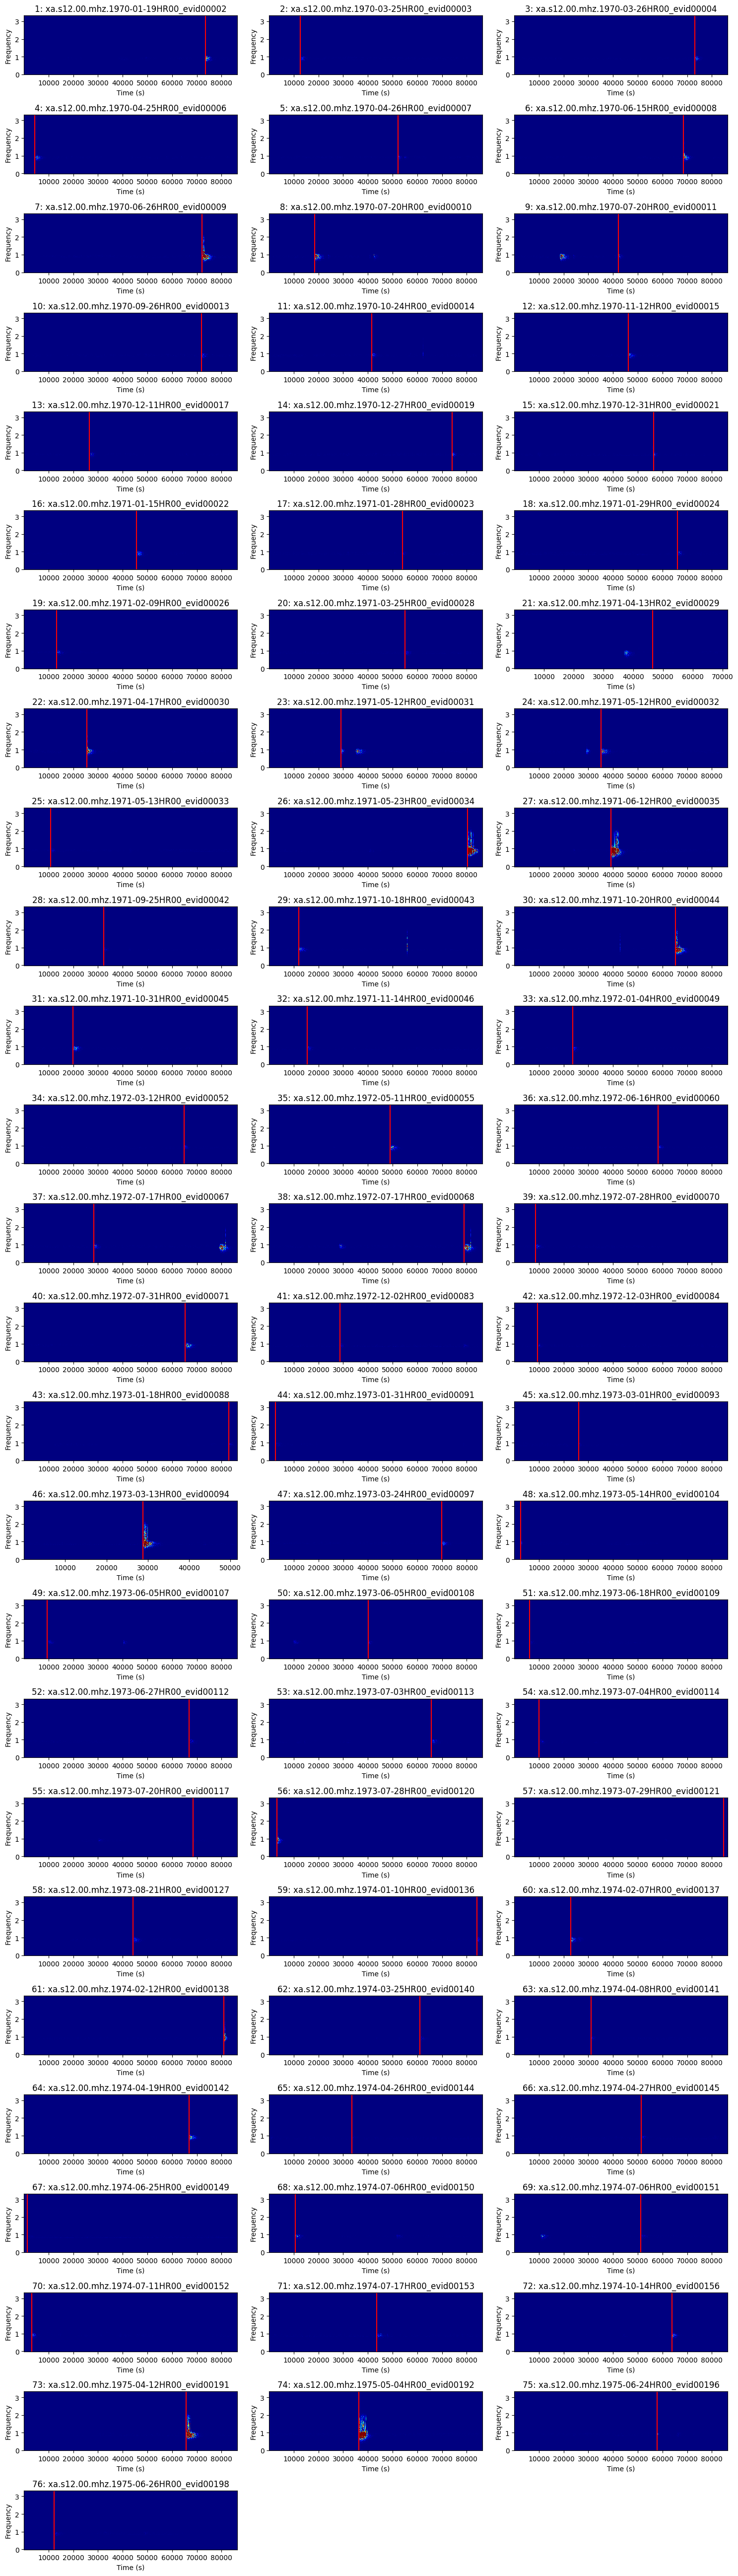

In [13]:
def spectrogram_viz(stream: obspy.core.stream.Stream):
    # all have just one trace
    trace = stream[0]
    tr_times = trace.times()
    tr_data = trace.data

    f, t, sxx = signal.spectrogram(tr_data, trace.stats.sampling_rate)
    return f, t, sxx


nrows = (len(train_streams) + 2) // 3
fig, axs = plt.subplots(nrows, 3, figsize=(15, 2 * nrows))
axs = axs.flatten()

unique_mq_types = cat["mq_type"].nunique()
color_map = plt.colormaps["tab10"]
color_dict = {mq: color_map(i) for i, mq in enumerate(cat["mq_type"].unique())}
for i, stream in enumerate(train_streams):
    f, t, sxx = spectrogram_viz(stream)

    mq_type = cat.loc[i, "mq_type"]
    color = color_dict[mq_type]

    axs[i].pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
    axs[i].axvline(x=cat.loc[i, "arrival_time_rel"], c="red")
    axs[i].set_title(f"{i+1}: {train_filenames[i].stem}")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Frequency")

for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

When the seismic data is visualized as a spectrogram. There are regions in the matrix where the power intensity is higher.(Colourful areas).

What if we decided to take the max intensity at each time step. This will give us a time series with max_power_intensity at a particular time.

Idea: To predict earthquakes, we can take the STA(short time period -- 2 seconds) and find the max point in that time series. That point can be the time when we detect the Earthquake.

In [14]:
def calculate_sta_lta(time_series, sta_length, lta_length):
    # Ensure input is a numpy array
    time_series = np.asarray(time_series)
    
    # Initialize STA and LTA arrays
    sta = np.zeros(len(time_series))
    lta = np.zeros(len(time_series))
    
    # Calculate STA
    for i in range(sta_length, len(time_series)):
        sta[i] = np.mean(time_series[i-sta_length:i])

    # Calculate LTA
    for i in range(lta_length, len(time_series)):
        lta[i] = np.mean(time_series[i-lta_length:i])

    # Avoid division by zero
    lta[lta == 0] = np.nan  # Set LTA to NaN where it's zero
    sta_lta_ratio = sta / lta
    
    return sta, lta, sta_lta_ratio

def sta_algo(stream: obspy.core.stream.Stream):
    # all have just one trace
    trace = stream[0]
    tr_times = trace.times()
    tr_data = trace.data

    f, t, sxx = signal.spectrogram(tr_data, trace.stats.sampling_rate)
    sta_n, lta_n, sta_by_lta = calculate_sta_lta(np.max(sxx, axis=0), 2, 100)
    return sta_n, t


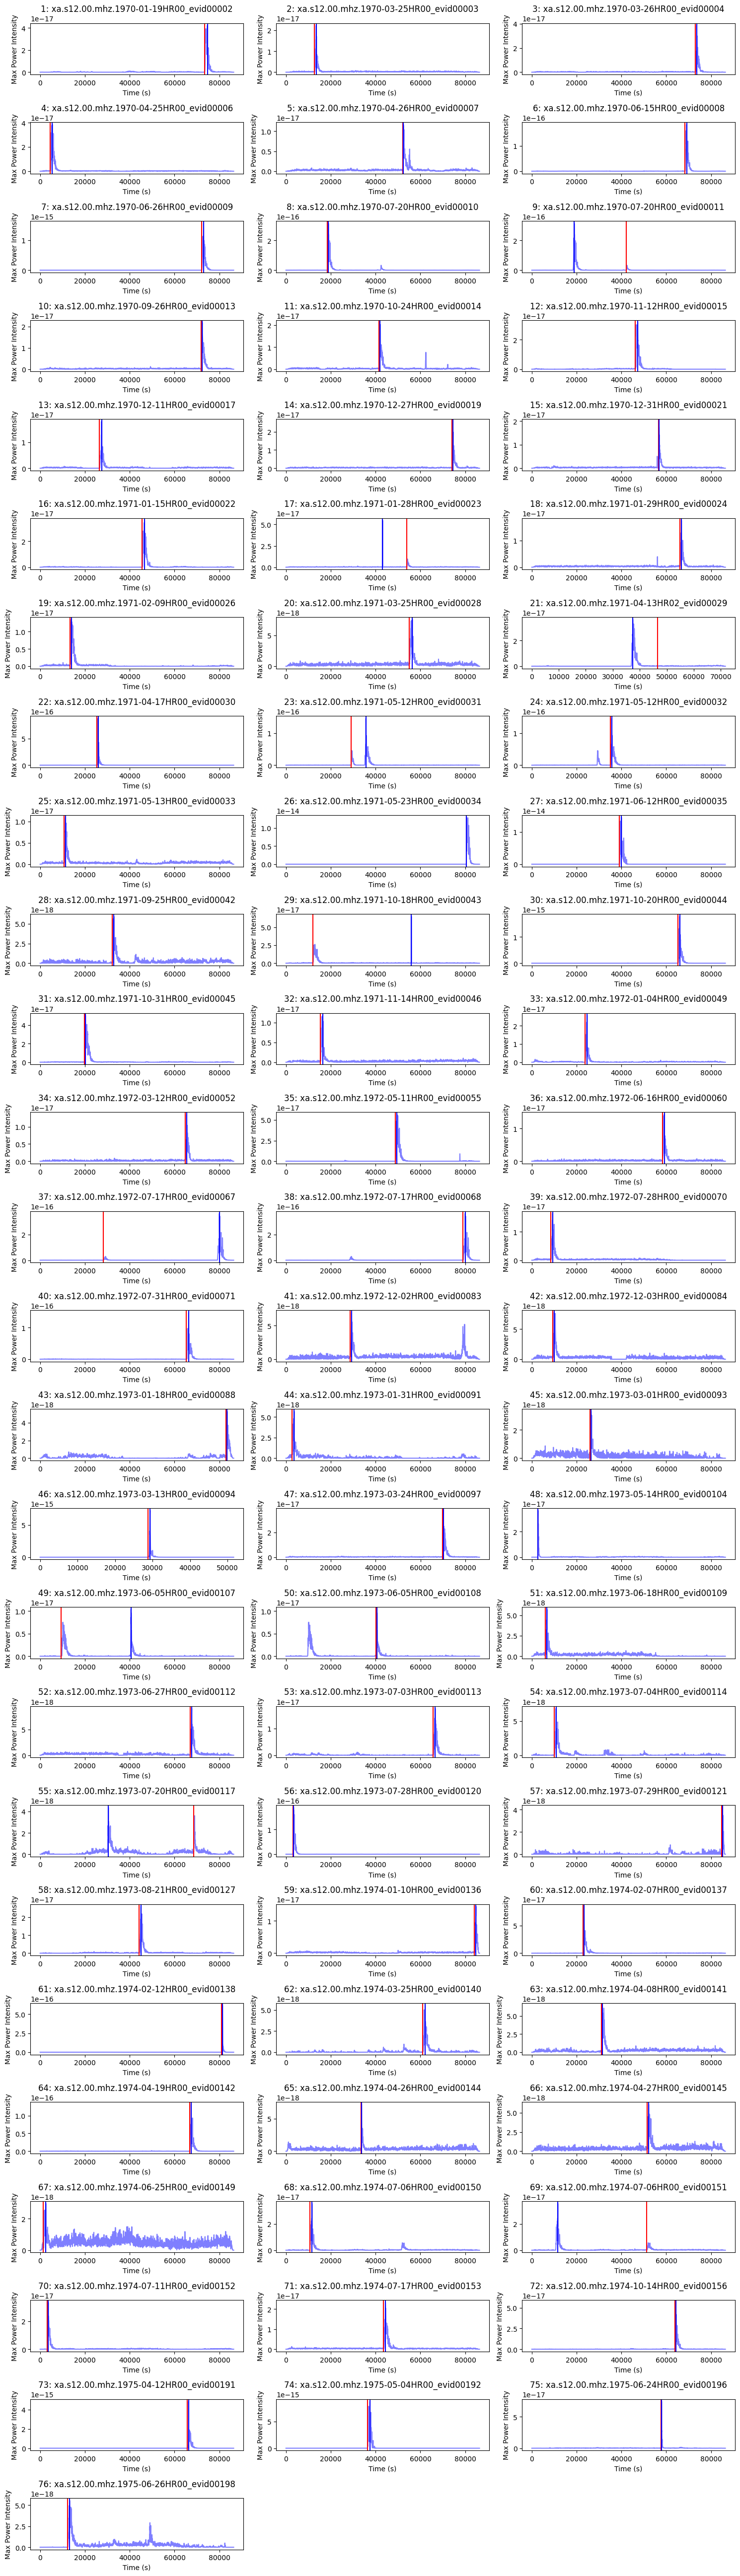

In [15]:


nrows = (len(train_streams) + 2) // 3
fig, axs = plt.subplots(nrows, 3, figsize=(15, 2 * nrows))
axs = axs.flatten()

unique_mq_types = cat["mq_type"].nunique()
color_map = plt.colormaps["tab10"]
color_dict = {mq: color_map(i) for i, mq in enumerate(cat["mq_type"].unique())}
for i, stream in enumerate(train_streams):
    sta_n, t  = sta_algo(stream)

    axs[i].plot(t, sta_n,  alpha=0.5, color="blue")
    axs[i].axvline(x=cat.loc[i, "arrival_time_rel"], c="red")
    axs[i].axvline(x=t[np.argmax(sta_n)], c="blue")
    axs[i].set_title(f"{i+1}: {train_filenames[i].stem}")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Max Power Intensity")

for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()

Blue: Our Prediction, Red: Original Prediction

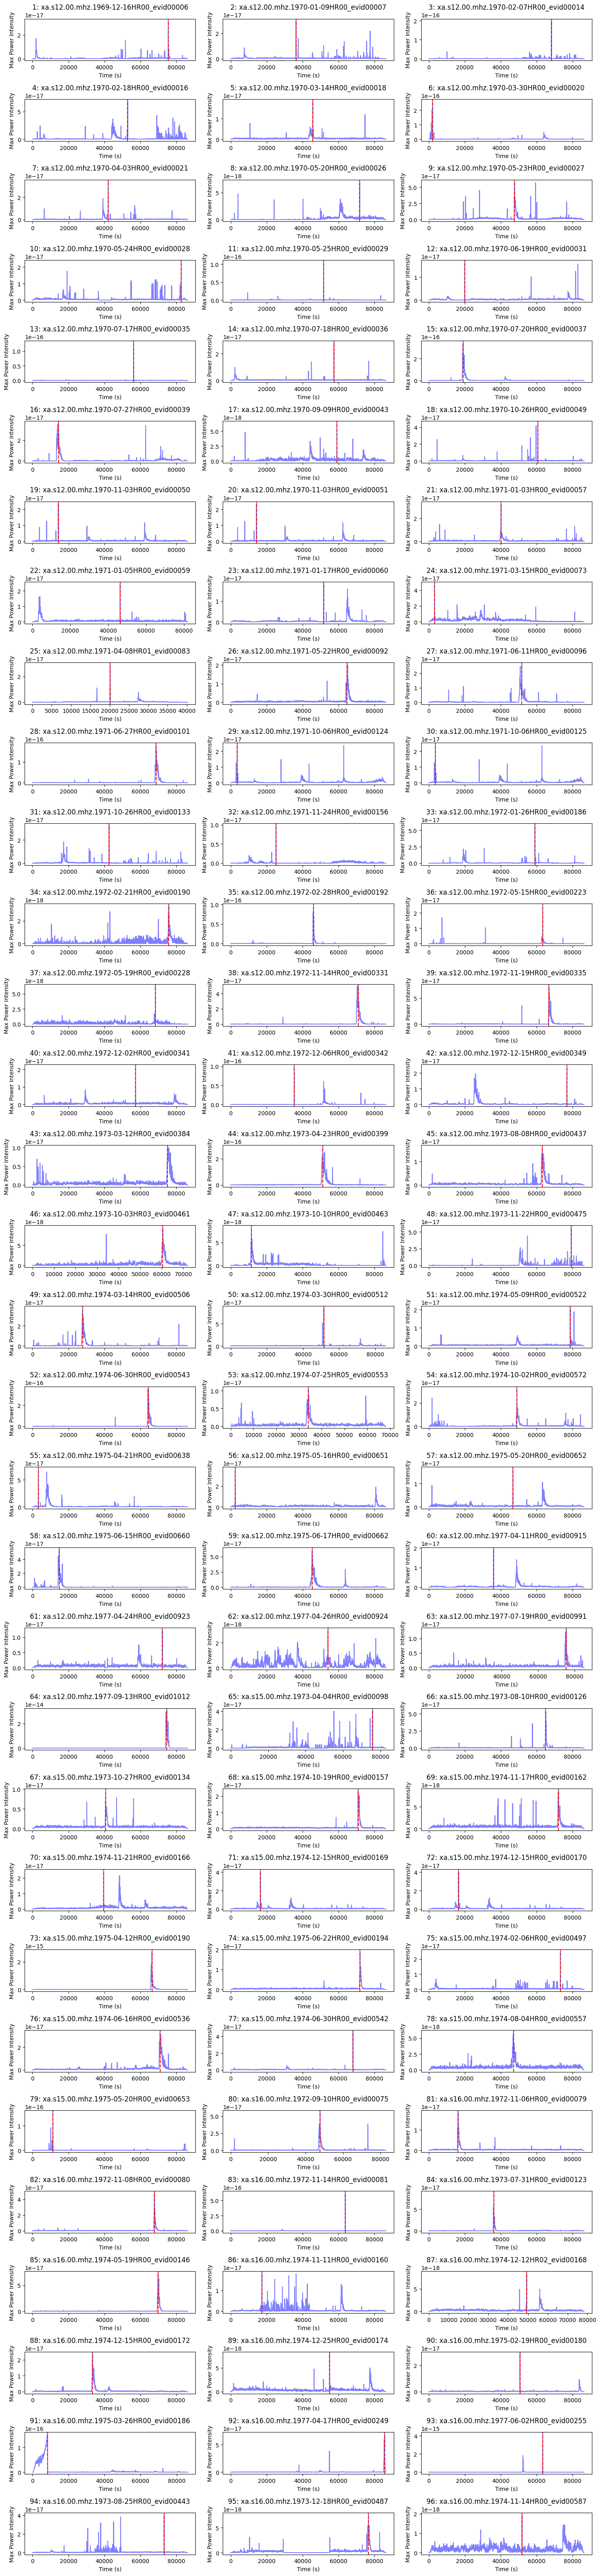

In [16]:
nrows = (len(test_streams) + 2) // 3
fig, axs = plt.subplots(nrows, 3, figsize=(15, 2 * nrows))
axs = axs.flatten()


for i, stream in enumerate(test_streams):
    sta_n, t = sta_algo(stream)

    axs[i].plot(t, sta_n,  alpha=0.5, color="blue")
    axs[i].axvline(x=t[np.argmax(sta_n)], c="red",  linestyle= "--" )
    axs[i].set_title(f"{i+1}: {test_filenames[i].stem}")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Max Power Intensity")

for j in range(i + 1, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()